## Cross Validation for Error Estimation and Model Selection

In [1]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from matplotlib import pyplot as plt

Cross validation has two related uses:
1. estimating a model's expected prediction error,
2. model selection.

### Estimating Prediction Error

Suppose I draw a random sample $$\mathcal{D} = \{(X_0, Y_n),\;\ldots,\;(X_{n-1},Y_{n-1})\}\qquad (n=50)$$ from the following distribution:

$$
\begin{aligned}
    X&\sim U[0,1]=\text{uniform distribution on [0,1]},\\[1ex]
    Y|X&\sim N\left(\sqrt{X}\sin(2\pi X)^2,\; 0.15\right).
\end{aligned}
$$

Write $p_{\text{data}}$ for this data generating distribution.

By construction, the regression function $r(X)$ of $Y$ on $X$ is

$$
r(X) = E[Y|X] = \sqrt{X}\sin(2\pi X)^2.
$$

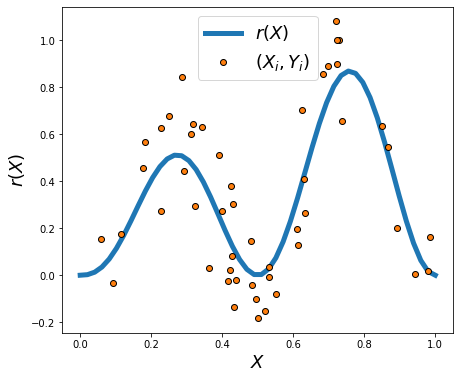

In [2]:
np.random.seed(123)

def r(u):
    return np.sqrt(u)*np.sin(2*np.pi*u)**2

u = np.linspace(0, 1)
plt.figure(figsize=(7,6))
plt.plot(u, r(u), lw=5, label="$r(X)$")
plt.xlabel("$X$", fontsize=18)
plt.ylabel("$r(X)$", fontsize=18);

n = 50
X = np.random.uniform(size=n).reshape(-1, 1)
E = np.random.normal(0, 0.15, size=n).reshape(-1, 1)
Y = r(X) + E
plt.plot(X, Y, 'o', mec='k', label="$(X_i,Y_i)$")
plt.legend(fontsize=18);

By fitting a $5$-nearest neighbors model to $\mathcal{D}$, I construct an approximation, $\widehat r_{\mathcal{D}}$, to $r$.

In [3]:
M = KNeighborsRegressor(n_neighbors=5)
M.fit(X.reshape(-1, 1), Y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

The **expected prediction error**, $\operatorname{EPE}(\hat r)$, is the expected value of $(\hat r(X)-Y)^2$, where $(X,Y)$ is a **new** data point drawn from the $p_{\text{data}}$:

$$
\operatorname{EPE}(\hat r_{\mathcal{D}}) = E_{(X,Y)\sim p_{\text{data}}}\left[\left(\hat r_{\mathcal{D}}(X)-Y\right)^2\right]\tag{$*$}
$$

We'd like to appriximate this quantity.

If we could sample a large, new **testing** data set,

$$
\mathcal{D'} = \{(X_0', Y_m'),\;\ldots,\;(X_{m-1}',Y_{m-1}')\}\qquad (m=10000)
$$

from $p_{\text{data}}$, we could average over that to produce a more reliable estimate of $(*)$. We call this estimate the **testing error**:

$$
\text{testing error} = \frac1m\sum_{i=0}^{n-1}\left(\hat r_\mathcal{D}(X_i') - Y_i'\right)^2
$$

In [4]:
m = 10000
X_test = np.random.uniform(size=m).reshape(-1, 1)
E_test = np.random.normal(0, 0.15, size=m).reshape(-1, 1)
Y_test = r(X_test) + E_test

Y_test_pred = M.predict(X_test.reshape(-1, 1))
test_error = np.mean(np.square(Y_test_pred - Y_test))
print(f"test error = {test_error}")

test error = 0.0371812076489526


However, when analyzing real data, it is extremely unlikely that you will be able to produce new data. You need to work with what you have!
The simplest way to do so would be to approximate $(*)$ averaging over the training set, $\mathcal{D}$. This gives the so-called **training error**:

$$
\text{training error} = \frac1n\sum_{i=0}^{n-1}\left(\hat r_\mathcal{D}(X_i) - Y_i\right)^2
$$
This is somewhat dubious, however, as the random vector $(X,Y)$ in the definition of $\operatorname{EPE}(\hat r)$ is supposed to be a **new** data point, not one of the ones used to fit the model. Thus, the training error typically **underestimates** $\operatorname{EPE}(\hat r)$.

In [5]:
Y_pred = M.predict(X.reshape(-1, 1))
train_error = np.mean(np.square(Y_pred - Y))
print(f"train error = {train_error}") # small!!

train error = 0.02854262805639619


$k$-fold cross validation is a compromise between the following two approaches: We construct several train/test splittings of our data set:

$$
\mathcal{D}_0\,/\,\mathcal{D}_{-0},\;\ldots,\;\mathcal{D}_{k-1}\,/\,\mathcal{D}_{-(k-1)},
$$

For each $i=0,\ldots,k-1$, train a new approximation, $\widehat{r}_{\mathcal{D}_{-i}}$, to $r$ on $\mathcal{D}_{-i}$ and test it on $\mathcal{D}_i$, giving $k$ testing error scores, $e_1,\ldots,e_k$.
The point of this is:

- Since $\mathcal{D}_{-i}$ is a large subset of $\mathcal{D}$, we should have
$$
\operatorname{EPE}(\hat r_{\mathcal{D}_{-i}}) \approx \operatorname{EPE}(\hat r_{\mathcal{D}}).
$$

- Since $\mathcal{D}_{-i}$ is disjoint from $\mathcal{D}_i$, the associated testing error
$$
e_i = \frac1n\sum_{(X_i', Y_i')\in \mathcal{D}_i}\left(\hat r_\mathcal{D}(X_i') - Y_i'\right)^2
$$
should be a good approximation of $\operatorname{EPE}(\hat r_{\mathcal{D}_{-i}})$:
$$
e_i\approx \operatorname{EPE}(\hat r_{\mathcal{D}_{-i}}).
$$

Putting the above two approximations together, we expect each $e_i$ to be a reasonable approximation to $\operatorname{EPE}(\hat r_{\mathcal{D}})$.
The average of these quantities,
$$
\frac1k(e_1+\cdots+ e_k)
$$
should be even better.  We use this **$k$-fold cross validation score** as a proxy for $\operatorname{EPE}(\hat r_{\mathcal{D}})$.

In [6]:
score = np.mean(-cross_val_score(M, X, Y, cv=5, scoring="neg_mean_squared_error"))
print(f"5-fold cross validation score = {score}") # better

5-fold cross validation score = 0.044067833010757826


### Model Selection

When choosing a model, we want to pick the one with the best prediction characteristics, i.e., the lowest expected prediction error.
Since the $k$-fold cross validation score gives a good estimate of this quantity, it makes sense to choose the model, among a set of candidates (e.g., obtained by varying parameters), with the lowest value of such.

optimal k = 5


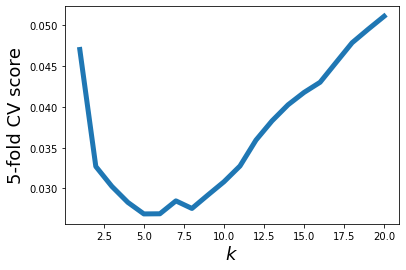

In [7]:
np.random.seed(123)

n = 100
X = np.random.uniform(size=n).reshape(-1, 1)
E = np.random.normal(0, 0.15, size=n).reshape(-1, 1)
Y = r(X) + E

scores = []
for k in range(1, 21):
    M = KNeighborsRegressor(n_neighbors=k)
    score = np.mean(-cross_val_score(M, X, Y, cv=5, scoring="neg_mean_squared_error"))
    scores.append(score)
plt.plot(range(1, 21), scores, lw=5)
plt.xlabel("$k$", fontsize=18)
plt.ylabel("5-fold CV score", fontsize=18)

optimal_k = np.argmin(scores) + 1
print(f"optimal k = {optimal_k}")